# GCN Model

### Import bibliotek

In [31]:
import pandas as pd
import torch
import json
from torch import nn
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import torch.optim as optim
import matplotlib.pyplot as plt

### Wczytanie datasetu z plików

In [32]:
def load_data():
    data_edges = pd.read_csv('DE_edges.csv')
    data_target = pd.read_csv('DE_target.csv')
    with open('DE.json') as f:
        node_features_json = json.load(f)
    node_features_df = pd.DataFrame.from_dict(node_features_json, orient='index')
    node_features_df.index.name = 'id'
    node_features_df.reset_index(inplace=True)
    return data_edges, data_target, node_features_df

### Preprocesowanie danych

In [33]:
def preprocess_data(data_target, data_edges, node_features_df):
    data_target = data_target.drop(columns=['id'])
    data_target = data_target.rename(columns={'new_id': 'id'})
    data_edges = data_edges.rename(columns={'from': 'from_id', 'to': 'to_id'})
    data_target['mature'] = data_target['mature'].astype(int)
    data_target['partner'] = data_target['partner'].astype(int)
    data_target['days'] = (data_target['days'] - data_target['days'].mean()) / data_target['days'].std()
    data_target['views'] = (data_target['views'] - data_target['views'].mean()) / data_target['views'].std()
    node_features = torch.tensor(data_target.drop(columns=['id']).values, dtype=torch.float)
    data_target['id'] = data_target['id'].astype('int64')
    node_features_df['id'] = node_features_df['id'].astype('int64')
    data_target = pd.merge(data_target, node_features_df, on='id')
    data_target = data_target.fillna(0)
    return data_target, data_edges, node_features

### Przygotowanie danych

In [34]:
def prepare_data(data_target, data_edges, node_features):
    edge_index = torch.tensor(data_edges.values, dtype=torch.long).t().contiguous()
    edge_index = torch.cat([edge_index, edge_index[[1, 0]]], dim=1)
    node_ids = data_target['id']
    node_to_idx = {node_id: idx for idx, node_id in enumerate(node_ids)}
    labels = torch.tensor(data_target['mature'].values, dtype=torch.long)
    x = torch.eye(len(node_ids))
    train_indices, test_indices = train_test_split(range(len(node_ids)), test_size=0.20, stratify=labels)
    train_mask = torch.zeros(len(node_ids), dtype=torch.bool).scatter_(0, torch.tensor(train_indices), True)
    test_mask = torch.zeros(len(node_ids), dtype=torch.bool).scatter_(0, torch.tensor(test_indices), True)
    data = Data(x=node_features, edge_index=edge_index, y=labels, train_mask=train_mask, test_mask=test_mask)
    return data

### Zdfiniowanie modelu GCN

In [35]:
class GCN(nn.Module):
    def __init__(self, node_features):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(node_features.shape[1], 32)
        self.conv2 = GCNConv(32, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

### Funkcja trenująca

In [36]:
def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

### Funkcja walidująca

In [37]:
def test(model, data):
    model.eval()
    out = model(data)
    pred = out.argmax(dim=1)
    correct = (pred[data.test_mask] == data.y[data.test_mask]).sum().item()
    accuracy = correct / int(data.test_mask.sum())
    return accuracy

### Funkcja rysująca wykresy acc/loss

In [38]:
def plot_results(loss_values, accuracy_values):
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(loss_values, label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over time')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(accuracy_values, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over time')
    plt.legend()

    plt.tight_layout()
    plt.show()

### Główna pętla programu

In [39]:
def main():
    data_edges, data_target, node_features_df = load_data()
    data_target, data_edges, node_features = preprocess_data(data_target, data_edges, node_features_df)
    data = prepare_data(data_target, data_edges, node_features)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = GCN(node_features).to(device)
    data = data.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss() 
    epochs = 2000
    loss_values = []
    accuracy_values = []
    for epoch in range(epochs):
        loss = train(model, data, optimizer, criterion)
        acc = test(model, data)
        loss_values.append(loss)
        accuracy_values.append(acc)
        print(f'Epoch: {epoch + 1:03d}, Loss: {loss:.4f}, Acc: {acc:.4f}')

    plot_results(loss_values, accuracy_values)

Epoch: 001, Loss: 0.6723, Acc: 0.6058
Epoch: 002, Loss: 0.6686, Acc: 0.6058
Epoch: 003, Loss: 0.6663, Acc: 0.6063
Epoch: 004, Loss: 0.6658, Acc: 0.6068
Epoch: 005, Loss: 0.6654, Acc: 0.6063
Epoch: 006, Loss: 0.6638, Acc: 0.6074
Epoch: 007, Loss: 0.6626, Acc: 0.6121
Epoch: 008, Loss: 0.6612, Acc: 0.6247
Epoch: 009, Loss: 0.6597, Acc: 0.6295
Epoch: 010, Loss: 0.6592, Acc: 0.6368
Epoch: 011, Loss: 0.6585, Acc: 0.6389
Epoch: 012, Loss: 0.6568, Acc: 0.6400
Epoch: 013, Loss: 0.6568, Acc: 0.6405
Epoch: 014, Loss: 0.6551, Acc: 0.6405
Epoch: 015, Loss: 0.6532, Acc: 0.6405
Epoch: 016, Loss: 0.6521, Acc: 0.6405
Epoch: 017, Loss: 0.6503, Acc: 0.6432
Epoch: 018, Loss: 0.6494, Acc: 0.6453
Epoch: 019, Loss: 0.6489, Acc: 0.6474
Epoch: 020, Loss: 0.6474, Acc: 0.6484
Epoch: 021, Loss: 0.6471, Acc: 0.6484
Epoch: 022, Loss: 0.6452, Acc: 0.6542
Epoch: 023, Loss: 0.6448, Acc: 0.6542
Epoch: 024, Loss: 0.6439, Acc: 0.6568
Epoch: 025, Loss: 0.6421, Acc: 0.6553
Epoch: 026, Loss: 0.6414, Acc: 0.6542
Epoch: 027, 

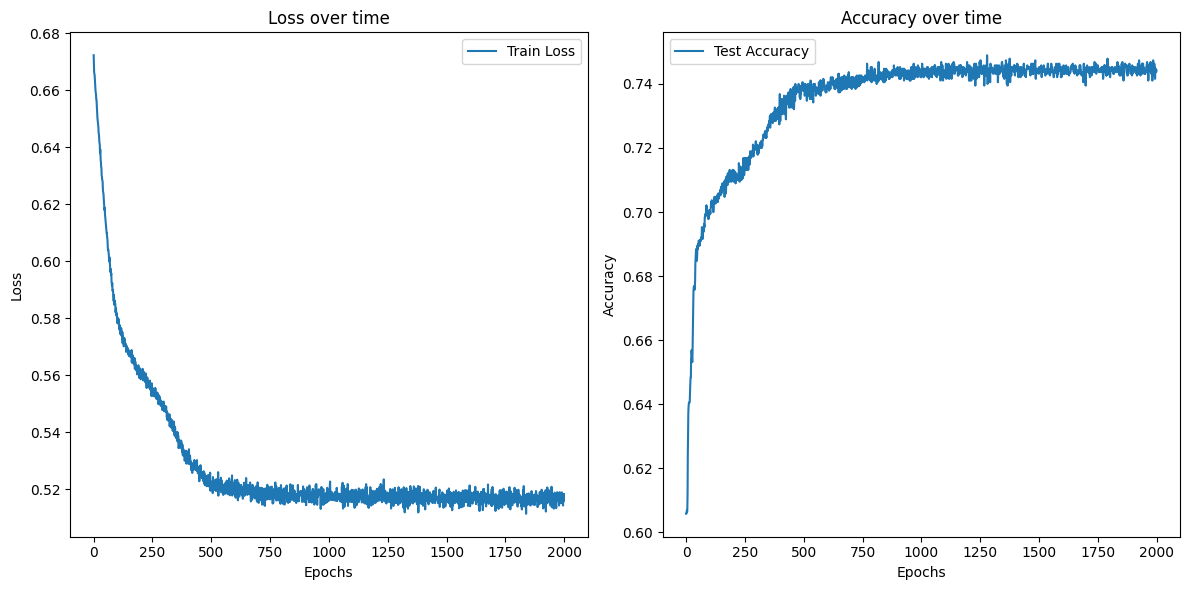

In [40]:
if __name__ == "__main__":
    main()